# KNN (K-Nearest Neighbors) is Dead!
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stephenleo/adventures-with-ann/blob/main/knn_is_dead.ipynb)

Long live ANNs for their whopping 380X speedup over sklearn's KNN while delivering 99.3% similar results.

![A Dead Tree in a desert](images/header.jpeg)

We're living through an extinction-level event. No, not COVID19, I'm talking about the demise of the popular KNN algorithm that is taught in pretty much every Data Science course! Read on to find out what's replacing this staple in every Data Scientists' toolkit.

# KNN Background
Finding "K" similar items to any given item is widely known in the machine learning community as a "similarity" search or "nearest neighbor" (NN) search. The most widely known NN search algorithm is the K-Nearest Neighbours (KNN) algorithm. In KNN, given a collection of objects like an e-commerce catalog of handphones, we can find a small number (K) nearest neighbors from this entire catalog for any new search query. For example, in the below example, if you set K = 3, then the 3 nearest neighbors for each "iPhone" is another "iPhone." Similarly, the 3 nearest neighbors to each "Samsung" are all Samsungs.

| Title                                              |
|----------------------------------------------------|
| Apple iPhone 12/12 Pro and 12 Pro max              |
| APPLE iPhone 12 2020 256GB SIM Free / Smart Phone  |
| Samsung Galaxy Note20 - Ultra/5G/LTE/4G w Warranty |
| APPLE IPHONE 12PRO MAX 256GB ONE YEAR WARRANTY     |
| New Release Samsung Note 20 4G / Note 20 Ultra 5G  |
| SAMSUNG GALAXY NOTE 20 ULTRA 5G                    |

## Issue with KNN
While KNN is great at finding similar items, it finds neighbors using an exhaustive pairwise distance computation. If your data contains 1000 items, then to find the K=3 nearest neighbors of a new product, the algorithm needs to perform 1000 distance computations of the new product to all the other products in your database. Well, that's not too bad, yet. But imagine a real-world Customer-to-Customer (C2C) marketplace with millions of products in the database and potentially thousands of new products uploaded every day. Comparing each new product to all the millions of products is wasteful and takes too much time, a.k.a not-scalable <b><i>at all</i></b>.

## The Solution
The solution to scale Nearest Neighbors to large data volumes is to sidestep the brute force distance computations completely and instead use a more sophisticated class of algorithms called Approximate Nearest Neighbors (ANN).

# Approximate Nearest Neighbors (ANN)
Strictly speaking, ANNs are a class of algorithms in which a small number of errors are allowed during the NN search. But in a real-world C2C marketplace where the number of "real" neighbors is higher than the "K" nearest neighbors being searched, ANNs can achieve remarkable accuracy on par with brute-force KNN within a fraction of the time. There are several ANN algorithms such as 
1. Spotify's [ANNOY](https://github.com/spotify/annoy)
2. Google's [ScaNN](https://github.com/google-research/google-research/tree/master/scann)
3. Facebook's [Faiss](https://github.com/facebookresearch/faiss)
3. And my personal favourite: Hierarchical Navigable Small World graphs [HNSW](https://github.com/nmslib/hnswlib)

The rest of this post benchmarks the KNN algorithm implemented in Python's `sklearn` to the excellent ANN algorithm called Hierarchical Navigable Small World (HNSW) graphs implemented in Python's `hnswlib` package. I'll use a large [Amazon product dataset](http://deepyeti.ucsd.edu/jianmo/amazon/) which contains 527000 products in the 'Cell Phones & Accessories' category to prove that HNSW is far superior in terms of speed (380X faster, to be precise) while delivering 99.3% similar results to sklearn's KNN.

## Hierarchical Navigable Small World (HNSW)
In HNSW [[paper @ arxiv]](https://arxiv.org/abs/1603.09320), the authors describe an ANN algorithm using a multi-layer graph. During element insertion, the HNSW graph is built incrementally by randomly selecting each element's maximum layer with an exponentially decaying probability distribution. This ensures that layer=0 has many elements to enable fine-search while layer=2 has $e^{-2}$ lower number of elements to facilitate coarse-search. The nearest neighbor search starts at the topmost layer with a coarse search and proceeds lower until the lowest layer using a greedy graph routing to traverse the graph and find the required number of neighbors.

![HNSW Graph Structure](images/hnsw_graph.png "HNSW graph structure. Nearest Neighbors search starts at the topmost layer (coarse search) and ends in the bottom-most layer (fine search)")

## HNSW Python package
The whole HNSW algorithm has been written in C++ with Python bindings that can be pip installed on your machine by typing: `pip install hnswlib`. Once you install the package and import it, creating the HNSW graph requires a few steps that I have wrapped into a convenience function below. Once you have created the HNSW index, querying for "K" nearest neighbors is as simple as calling a single line of code as below.

```
ann_neighbor_indices, ann_distances = p.knn_query(features, k)
```

In [ ]:
!pip install hnswlib

In [1]:
import hnswlib
import numpy as np

def fit_hnsw_index(features, ef=100, M=16, save_index_file=False):
    # Convenience function to create HNSW graph
    # features : list of lists containing the embeddings
    # ef, M: parameters to tune the HNSW algorithm
    
    num_elements = len(features)
    labels_index = np.arange(num_elements)
    EMBEDDING_SIZE = len(features[0])
    
    # Declaring index
    # possible space options are l2, cosine or ip
    p = hnswlib.Index(space='l2', dim=EMBEDDING_SIZE)
    
    # Initing index - the maximum number of elements should be known
    p.init_index(max_elements=num_elements, ef_construction=ef, M=M)
    
    # Element insertion
    int_labels = p.add_items(features, labels_index)
    
    # Controlling the recall by setting ef
    # ef should always be > k
    p.set_ef(ef) 
    
    # If you want to save the graph to a file
    if save_index_file:
         p.save_index(save_index_file)
    
    return p

# KNN vs. ANN Benchmarking Experiment
## Plan
We'll first download a large dataset with 500K+ rows. Then we'll convert a text column to an `300d` embedding vector by using the pre-trained `fasttext` sentence vector. Then I'll train both KNN and HNSW ANN models on different lengths of the input data `[1000, 10000, 100000, len(data)]` to measure the impact of data size on the speed. Finally, I'll query `K = 10` and `100` nearest neighbors from both models to measure the impact of `K` on the speed. First, let's import the necessary packages and models. This will take some time as the `fasttext` model needs to be downloaded from the internet.

In [1]:
# Imports
# For input data pre-processing
import json
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore') # English pre-trained model
ft = fasttext.load_model('cc.en.300.bin')

# For KNN vs ANN benchmarking
from datetime import datetime
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import hnswlib

## Data
We'll use the [Amazon product dataset](http://deepyeti.ucsd.edu/jianmo/amazon/), which contains 527000 products in the 'Cell Phones & Accessories' category. Download the dataset from the link and run the below code to convert it to a data frame. We only need the product title column as we will use it to search for similar products.

If everything ran fine, you should see an output as below.

In [2]:
# Data: http://deepyeti.ucsd.edu/jianmo/amazon/
data = []
with gzip.open('meta_Cell_Phones_and_Accessories.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

In [3]:
# Pre-Processing: https://colab.research.google.com/drive/1Zv6MARGQcrBbLHyjPVVMZVnRWsRnVMpV#scrollTo=LgWrDtZ94w89
# Convert list into pandas dataframe
df = pd.DataFrame.from_dict(data)
df.fillna('', inplace=True)

# Filter unformatted rows
df = df[~df.title.str.contains('getTime')] 

# Restrict to just 'Cell Phones and Accessories'
df = df[df['main_cat']=='Cell Phones & Accessories']

# Reset index
df.reset_index(inplace=True, drop=True)

# Only keep the title columns
df = df[['title']]

# Check the df
print(df.shape)
df.head()

(527543, 1)


,title
0,Puppies Faceplate Hard Case Protector for Net1...
1,White Wolf Faceplate Protector Hard Case for S...
2,Camo Duck Grass Rubberized Hard Case Phone Fac...
3,Camoflague Camo Usa Deer Combo Hybrid Hard Cas...
4,Motorola H700 Black - Non-Retail Packaging


## Embedding
To run any similarity search on textual data, we must first convert it to a numeric vector. A fast and convenient approach uses a pre-trained network's embedding layer, such as the one provided by Facebook's [FastText](https://github.com/facebookresearch/fastText). Since we want all the rows to have the same length vector, irrespective of the number of words in the title, we shall apply the `get_sentence_vector` method on the `title` column in df. Once the embedding is completed, we extract the `emb` column as a list of lists to input into our NN algorithms. Ideally, you would run some text cleaning pre-processing before this step. Also, using a fine-tuned embedding model is generally a good idea. 

In [4]:
# Title Embedding using FastText Sentence Embedding
df['emb'] = df['title'].apply(ft.get_sentence_vector)

# Extract out the embeddings column as a list of lists for input to our NN algos
X = [item.tolist() for item in df['emb'].values]

527543


## Benchmarking
Now that we have the input to our algorithms let's run the benchmarking tests. We will run the test as a loop within a loop of the number of products in the search space and `K` nearest neighbors being searched. 

At each iteration, in addition to clocking the time taken by each algorithm, we check the `pct_overlap` as the ratio of the number of KNN nearest neighbors that were also picked up as nearest neighbors by the ANN.

<b>Beware!</b> The whole test ran for ~6days on an 8 core, 30 GB RAM machine running 24x7, so this could take some time. Ideally, you could speed it up by multiprocessing since each run is independent of the other.

The output at the end of this run looks as below. As you can already see from the table, the HNSW ANN completely blows away KNN!

In [ ]:
# Number of products for benchmark loop
n_products = [1000, 10000, 100000, len(X)]

# Number of neighbors for benchmark loop
n_neighbors = [10, 100]

# Dictionary to save metric results for each iteration
metrics = {'products':[], 'k':[], 'knn_time':[], 'ann_time':[], 'pct_overlap':[]}

for products in tqdm(n_products):
    # "products" number of products included in the search space
    features = X[:products]
    
    for k in tqdm(n_neighbors):   
        # "K" Nearest Neighbor search
        # KNN 
        knn_start = datetime.now()
        nbrs = NearestNeighbors(n_neighbors=k, metric='euclidean').fit(features)
        knn_distances, knn_neighbor_indices = nbrs.kneighbors(features)
        knn_end = datetime.now()
        metrics['knn_time'].append((knn_end - knn_start).total_seconds())
        
        # HNSW ANN
        ann_start = datetime.now()
        p = fit_hnsw_index(features, ef=k*10)
        ann_neighbor_indices, ann_distances = p.knn_query(features, k)
        ann_end = datetime.now()
        metrics['ann_time'].append((ann_end - ann_start).total_seconds())
        
        # Average Percent Overlap in Nearest Neighbors across all "products"
        pct_overlap_per_product = [len(np.intersect1d(knn_neighbor_indices[i], ann_neighbor_indices[i]))/k for i in range(len(features))]
        metrics['pct_overlap'].append(np.mean(pct_overlap_per_product))
        
        metrics['products'].append(products)
        metrics['k'].append(k)
        
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv('data/metrics_df.csv', index=False)

In [2]:
metrics_df

,products,k,knn_time,ann_time,pct_overlap
0,1000,10,0.580620,0.051501,0.997700
1,1000,100,0.597760,0.126358,0.999990
2,10000,10,63.103122,0.652903,0.979910
3,10000,100,64.446671,3.155929,0.999258
4,100000,10,6234.982191,11.146112,0.964912
5,100000,100,6331.495806,83.650471,0.995826
6,527543,10,222900.147851,85.357864,0.935081
7,527543,100,243439.207189,634.716238,0.992623


## Results
Let's look at the benchmark results in the form of plots to appreciate the difference's magnitude truly. I'll use standard `matplotlib` code to plot these graphs. The X-axis is in `log` scale. The difference is spectacular! HNSW ANN knocks KNN out of the park in terms of time required to query `K=10` and `100` nearest neighbors. When the search space contains `~500K` products, searching for 100 nearest neighbors is 380X faster on ANN!!! At the same time, both KNN and ANN find 99.3% same nearest neighbors. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
metrics_df = pd.read_csv('data/metrics_df.csv')
metrics_df.head()

,products,k,knn_time,ann_time,pct_overlap
0,1000,10,0.580620,0.051501,0.997700
1,1000,100,0.597760,0.126358,0.999990
2,10000,10,63.103122,0.652903,0.979910
3,10000,100,64.446671,3.155929,0.999258
4,100000,10,6234.982191,11.146112,0.964912


/home/stephenleo/anaconda3/envs/ann/lib/python3.6/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


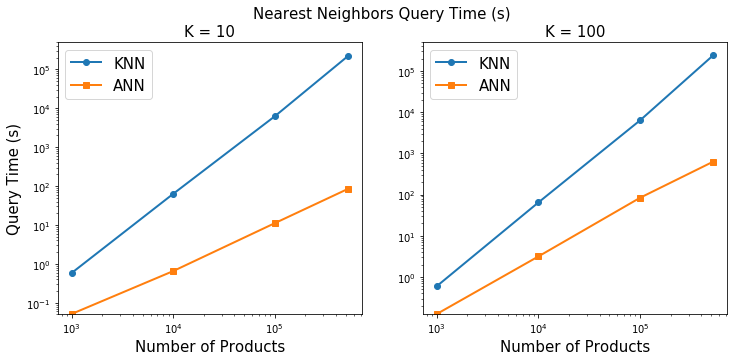

In [3]:
k10_df = metrics_df[metrics_df['k']==10]
k100_df = metrics_df[metrics_df['k']==100]

fig = plt.figure(figsize=(12,5))
fig.patch.set_facecolor('white')

ax1 = fig.add_subplot(1,2,1)
ax1.plot(k10_df['products'].values, k10_df['knn_time'].values, label='KNN', linewidth=2, marker='o')
ax1.plot(k10_df['products'].values, k10_df['ann_time'].values, label='ANN', linewidth=2, marker='s')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(0, 500000)
ax1.legend(fontsize=15)
ax1.set_title('K = 10', fontsize=15)
ax1.set_xlabel('Number of Products', fontsize=15)
ax1.set_ylabel('Query Time (s)', fontsize=15)

ax2 = fig.add_subplot(1,2,2)
ax2.plot(k100_df['products'].values, k100_df['knn_time'].values, label='KNN', linewidth=2, marker='o')
ax2.plot(k100_df['products'].values, k100_df['ann_time'].values, label='ANN', linewidth=2, marker='s')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim(0, 500000)
ax2.legend(fontsize=15)
ax2.set_title('K = 100', fontsize=15)
ax2.set_xlabel('Number of Products', fontsize=15)

plt.suptitle('Nearest Neighbors Query Time (s)', fontsize=15);

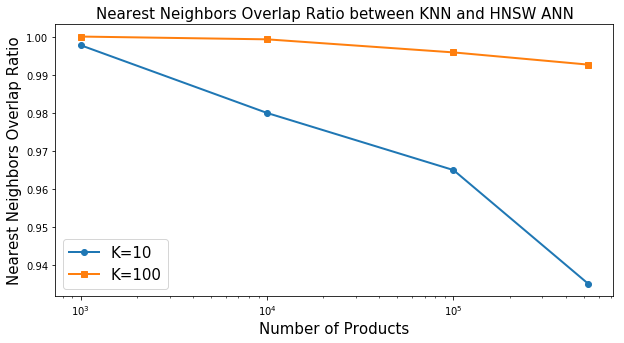

In [5]:
fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('white')
plt.plot(k10_df['products'].values, k10_df['pct_overlap'].values, label='K=10', linewidth=2, marker='o')
plt.plot(k100_df['products'].values, k100_df['pct_overlap'].values, label='K=100', linewidth=2, marker='s')
plt.title('Nearest Neighbors Overlap Ratio between KNN and HNSW ANN', fontsize=15)
plt.xlabel('Number of Products', fontsize=15)
plt.ylabel('Nearest Neighbors Overlap Ratio', fontsize=15)
plt.legend(fontsize=15)
plt.xscale('log')

With these results, I think it's safe to say, "KNN is dead!", there is no reasonable reason to use `sklearn's` KNN anymore. I hope you found this post useful! Thank you for reading!